# Tests ForecasterAutoregMultiseries when series have different lengths and different exogenous variables

In [24]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent.parent)
sys.path.insert(1, path)
print(path)

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skforecast.plot import set_dark_theme
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.metrics import mean_absolute_scaled_error
from skforecast.metrics import root_mean_squared_scaled_error
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    backtesting_forecaster_multiseries,
    bayesian_search_forecaster_multiseries,
    grid_search_forecaster_multiseries
)
import warnings
import sys

print(f"Python version: {sys.version}")
print(f"skforecast version: {skforecast.__version__}")
print(f"lightgbm version: {lightgbm.__version__}")
print(f"sklearn version: {sklearn.__version__}")
print(f"Last execution: {pd.Timestamp.now()}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/ubuntu/varios/skforecast
Python version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:56:27) [GCC 11.2.0]
skforecast version: 0.15.0
lightgbm version: 4.6.0
sklearn version: 1.5.2
Last execution: 2025-03-13 12:43:47.431284


In [14]:
# Load time series of multiple lengths
# ==============================================================================
# series_dict = joblib.load('sample_multi_series.joblib')
# exog_dict = joblib.load('sample_multi_series_exog.joblib')
series = pd.read_csv("../fixtures/sample_multi_series.csv")
exog = pd.read_csv("../fixtures/sample_multi_series_exog.csv")
series["timestamp"] = pd.to_datetime(series["timestamp"])
exog["timestamp"] = pd.to_datetime(exog["timestamp"])

series_dict = series_long_to_dict(
    data=series, series_id="series_id", index="timestamp", values="value", freq="D"
)
exog_dict = exog_long_to_dict(
    data=exog, series_id="series_id", index="timestamp", freq="D"
)
series_dict["id_1002"].at["2016-02-01"] = np.nan
series_dict["id_1002"].at["2016-05-01"] = np.nan
exog_dict["id_1000"] = exog_dict["id_1000"].drop(
    columns=["air_temperature", "wind_speed"]
)
exog_dict["id_1003"] = exog_dict["id_1003"].drop(columns=["cos_day_of_week"])

In [15]:
# Partition data in train and test
# ==============================================================================
end_train = "2016-07-31 23:59:00"
series_dict_train = {k: v.loc[:end_train,] for k, v in series_dict.items()}
exog_dict_train = {k: v.loc[:end_train,] for k, v in exog_dict.items()}
series_dict_test = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

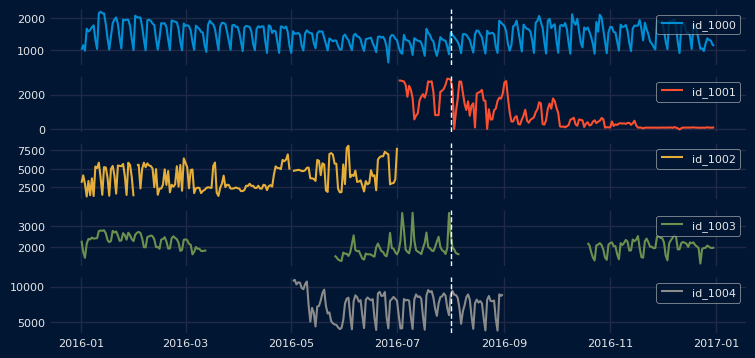

In [16]:
# Plot series
# ==============================================================================
set_dark_theme()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc="upper right", fontsize=8)
    axs[i].tick_params(axis="both", labelsize=8)
    axs[i].axvline(
        pd.to_datetime(end_train), color="white", linestyle="--", linewidth=1
    )

In [17]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"\tTrain: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except:
        print(f"\tTrain: len=0")
    try:
        print(
            f"\tTest : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except:
        print(f"\tTest : len=0")

id_1000:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
	Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
	Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
	Test : len=0
id_1003:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
	Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00


In [18]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"\t{exog_dict[k].columns.to_list()}")
    except:
        print(f"\tNo exogenous variables")

id_1000:
	['sin_day_of_week', 'cos_day_of_week']
id_1001:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1002:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1003:
	['sin_day_of_week', 'air_temperature', 'wind_speed']
id_1004:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']


In [11]:
# Test predict
# ==============================================================================
params = {
    "encoding": ["ordinal", "onehot", "ordinal_category"],
    "dropna_from_series": [False, True],
    "interval": [[5, 95]],
    "n_boot": [10],
}

params_grid = list(ParameterGrid(params))

for params in tqdm(params_grid):
    print(f"Paramns: {params}")

    forecaster = ForecasterRecursiveMultiSeries(
        regressor=LGBMRegressor(
            n_estimators=2, random_state=123, verbose=-1, max_depth=2
        ),
        lags=14,
        encoding=params["encoding"],
        dropna_from_series=params["dropna_from_series"],
        transformer_series=StandardScaler(),
        transformer_exog=StandardScaler(),
    )
    forecaster.fit(
        series=series_dict_train, exog=exog_dict_train, suppress_warnings=True,
        store_in_sample_residuals=True
    )
    predictions = forecaster.predict(
        steps=5, exog=exog_dict_test, suppress_warnings=True
    )
    predictions_int = forecaster.predict_interval(
        steps=5,
        exog=exog_dict_test,
        interval=params["interval"],
        n_boot=params["n_boot"],
        suppress_warnings=True,
    )

  0%|          | 0/6 [00:00<?, ?it/s]

Paramns: {'dropna_from_series': False, 'encoding': 'ordinal', 'interval': [5, 95], 'n_boot': 10}
Paramns: {'dropna_from_series': False, 'encoding': 'onehot', 'interval': [5, 95], 'n_boot': 10}
Paramns: {'dropna_from_series': False, 'encoding': 'ordinal_category', 'interval': [5, 95], 'n_boot': 10}
Paramns: {'dropna_from_series': True, 'encoding': 'ordinal', 'interval': [5, 95], 'n_boot': 10}
Paramns: {'dropna_from_series': True, 'encoding': 'onehot', 'interval': [5, 95], 'n_boot': 10}


ValueError: X has 21 features, but LGBMRegressor is expecting 23 features as input.

In [21]:
# Test backtesting
# ==============================================================================
params = {
    "initial_train_size": [50, len(series_dict_train["id_1000"])],
    "refit": [True, False, 2],
    "fixed_train_size": [True, False],
    "gap": [0, 7],
    "levels": [
        None,
        ["id_1000", "id_1001", "id_1002", "id_1003", "id_1004"],
        "id_1000",
        ["id_1000", "id_1001"],
    ],
    "metrics": [["mean_absolute_error", "mean_squared_error"], "mean_absolute_error"],
    "allow_incomplete_fold": [True, False],
}

params_grid = list(ParameterGrid(params))

for params in tqdm(params_grid):
    print(f"Paramns: {params}")

    forecaster = ForecasterRecursiveMultiSeries(
        regressor=LGBMRegressor(
            n_estimators=2, random_state=123, verbose=-1, max_depth=2
        ),
        lags=14,
        encoding="ordinal",
        dropna_from_series=False,
        transformer_series=StandardScaler(),
        transformer_exog=StandardScaler(),
    )

    cv = TimeSeriesFold(
        initial_train_size=params["initial_train_size"],
        steps=24,
        fixed_train_size=params["fixed_train_size"],
        gap=params["gap"],
        allow_incomplete_fold=params["allow_incomplete_fold"],
        refit=params["refit"],
    )

    metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=series_dict,
        exog=exog_dict,
        levels=params["levels"],
        cv = cv,
        metric=params["metrics"],
        show_progress=False,
        suppress_warnings=True,
        n_jobs="auto"
    )

  0%|          | 0/384 [00:00<?, ?it/s]

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': True}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': False}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_tra

KeyboardInterrupt: 

In [22]:
# Test Bayesian search
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1, max_depth=2),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

lags_grid = [[5], [1, 7, 14]]


def search_space(trial):
    search_space = {
        "n_estimators": trial.suggest_int("n_estimators", 2, 5),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "lags": trial.suggest_categorical("lags", lags_grid),
    }

    return search_space


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

    cv = TimeSeriesFold(
        initial_train_size=len(series_dict_train["id_1000"]),
        steps=10,
        refit=False,
    )

    results_search, best_trial = bayesian_search_forecaster_multiseries(
        forecaster=forecaster,
        series=series_dict,
        exog=exog_dict,
        search_space=search_space,
        metric="mean_absolute_error",
        cv=cv,
        n_trials=3,
        return_best=False,
        show_progress=True,
        verbose=False,
        suppress_warnings=True,
    )

  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
# Test Grid Search
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1, max_depth=2),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

lags_grid = [[5], [1, 7, 14]]

param_grid = {
    "learning_rate": [0.1],
    "n_estimators": [10, 20],
    "max_depth": [2, 5],
}

cv = TimeSeriesFold(
        initial_train_size=len(series_dict_train["id_1000"]),
        steps=10,
        refit=False,
    )

results_search = grid_search_forecaster_multiseries(
    forecaster=forecaster,
    series=series_dict,
    exog=exog_dict,
    lags_grid=lags_grid,
    param_grid=param_grid,
    metric="mean_absolute_error",
    cv=cv,
    return_best=False,
    show_progress=True,
    verbose=False,
    suppress_warnings=True,
)

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
# Test equivalent results grid search with backtesting and one-step-ahead
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1, max_depth=2),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

lags_grid = [[5], [1, 7, 14]]

param_grid = {
    "learning_rate": [0.1],
    "n_estimators": [10, 20],
    "max_depth": [2, 5],
}

metrics = [
        "mean_absolute_error",
        "mean_squared_error",
        mean_absolute_percentage_error,
        mean_absolute_scaled_error,
        root_mean_squared_scaled_error,
    ]

cv = TimeSeriesFold(
        initial_train_size=len(series_dict_train["id_1000"]),
        steps=1,
        refit=False,
    )

results_backtesting = grid_search_forecaster_multiseries(
    forecaster=forecaster,
    series=series_dict,
    exog=exog_dict,
    lags_grid=lags_grid,
    param_grid=param_grid,
    metric=metrics,
    cv=cv,
    return_best=False,
    show_progress=True,
    verbose=False,
    suppress_warnings=True,
)

cv = OneStepAheadFold(
    initial_train_size=len(series_dict_train["id_1000"]),
)
results_one_step_ahead = grid_search_forecaster_multiseries(
    forecaster=forecaster,
    series=series_dict,
    exog=exog_dict,
    lags_grid=lags_grid,
    param_grid=param_grid,
    metric=metrics,
    cv=cv,
    return_best=False,
    show_progress=True,
    verbose=False,
    suppress_warnings=True,
)

pd.testing.assert_frame_equal(results_backtesting, results_one_step_ahead)

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]